(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week09/notebook/demo.ipynb)

# Work with Imbalanced Data

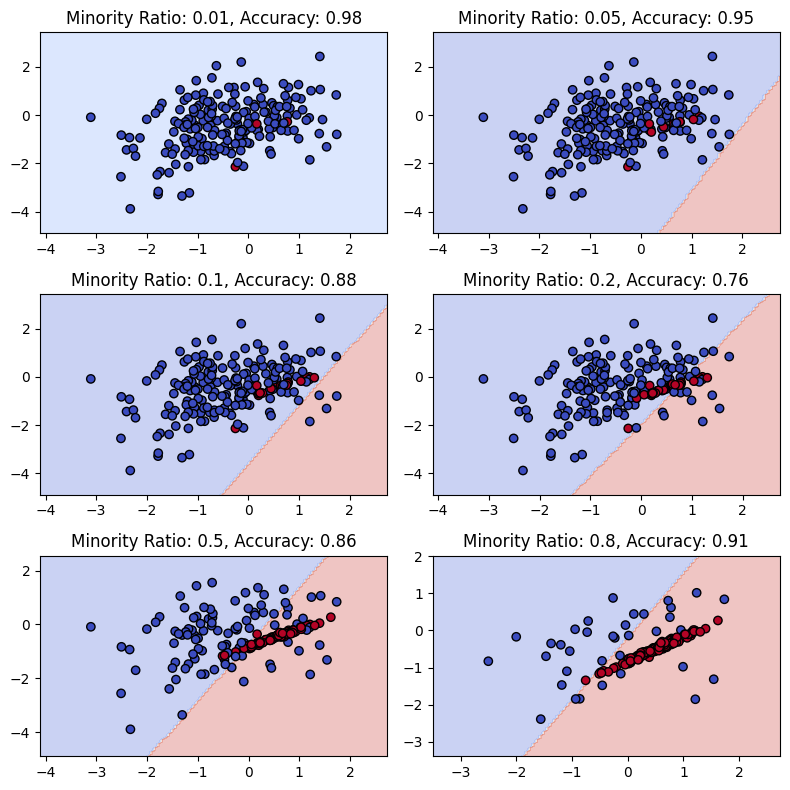

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def generate_imbalanced_dataset(n_sample=1000, minority_ratio=0.05, random_state=1234):
    X, y = make_classification(n_samples=n_sample, n_features=2, n_redundant=0, n_clusters_per_class=1,
                               weights=[1 - minority_ratio, minority_ratio], class_sep=0.5, random_state=random_state)
    return X, y

# Function to plot decision boundaries
def plot_decision_boundaries(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

inputs_to_visualize = []
for minority_ratio in [0.01, 0.05, 0.1, 0.2, 0.5, 0.8]:
    # Generate an imbalanced dataset
    X, y = generate_imbalanced_dataset(minority_ratio=minority_ratio)
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Fit a logistic regression model
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    # Check the accuracy
    accuracy = model.score(X_test, y_test)
    # Store the input data for visualization
    inputs_to_visualize.append((minority_ratio, model, X_test, y_test, accuracy))

# visualize all in a 1x3 grid
nrow, ncol = 3, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(8, 8))
for i, (minority_ratio, model, X_test, y_test, accuracy) in enumerate(inputs_to_visualize):
    plot_decision_boundaries(model, X_test, y_test, axes[i//ncol][i%ncol], f"Minority Ratio: {minority_ratio}, Accuracy: {accuracy:.2f}")
plt.tight_layout()
plt.show()


# SMOTE (Synthetic Minority Over-sampling Technique)